In [1]:
#Importamos librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

In [2]:
#Accedemos a google drive para traer el csv y las imágenes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Cargamos el csv de la metadata
metadata_path = '/content/drive/MyDrive/KeepCoding_FullStack_AI_Bootcamp/DeepLearning/Project/Data/HAM10000_metadata.csv'
metadata_df = pd.read_csv('/content/drive/MyDrive/KeepCoding_FullStack_AI_Bootcamp/DeepLearning/Project/Data/HAM10000_metadata.csv')

#Y ahora el csv de las imágenes
images_path = '/content/drive/MyDrive/KeepCoding_FullStack_AI_Bootcamp/DeepLearning/Project/Data/hnmist_28_28_RGB.csv'
images_csv = pd.read_csv(images_path)

In [4]:
#Veamos que dimensiones tienen ambos conjuntos de datos
print('Dimensiones dataframe metadata: ', metadata_df.shape)
print('Dimensiones dataframe imágenes: ', images_csv.shape)

Dimensiones dataframe metadata:  (10015, 7)
Dimensiones dataframe imágenes:  (10015, 2352)


In [5]:
#Echemos un vistazo rápido a los datos
metadata_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
images_csv.head(5)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92


In [7]:
#Veamos los tipos de datos que tenemos
metadata_df.dtypes

,0
lesion_id,object
image_id,object
dx,object
dx_type,object
age,float64
sex,object
localization,object


Vamos a eliminar columnas que no aportan ningún conocimiento a nuestra red

In [8]:
#Hacemos un drop de esas columnas
print('Dimensiones dataframe metadata antes: ', metadata_df.shape)
metadata_df.drop(columns=['lesion_id', 'image_id', 'dx_type'], inplace=True)
print('Dimensiones dataframe metadata después: ', metadata_df.shape)

Dimensiones dataframe metadata antes:  (10015, 7)
Dimensiones dataframe metadata después:  (10015, 4)


In [9]:
#Revisemos si tenemos alguna columna que contenga valores nulos
metadata_df.isna().sum()

,0
dx,0
age,57
sex,0
localization,0


Veo que tenemos 57 valores nulos en la columna `age`, revisaré si estos registros nulos están repartidos de manera equitativa en todas las clases o si son todos de una clase en particular, en caso de que estén repartidos entre todas las clases y ninguna clase pierda registros importantes procederé a eliminarlos, caso contrario tendré que imputarlos.

<Axes: xlabel='dx', ylabel='Count'>

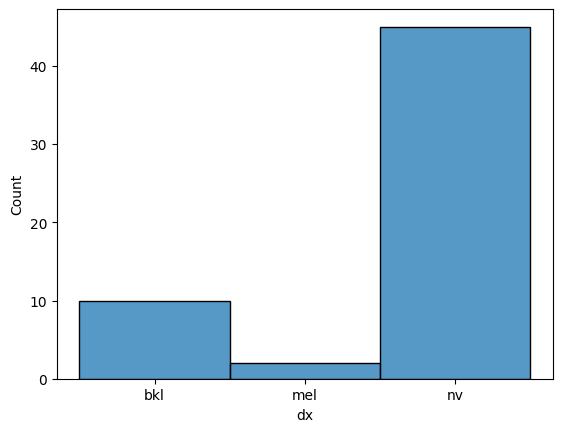

In [10]:
sns.histplot(data=metadata_df[metadata_df['age'].isna()], x='dx')

<Axes: xlabel='dx', ylabel='Count'>

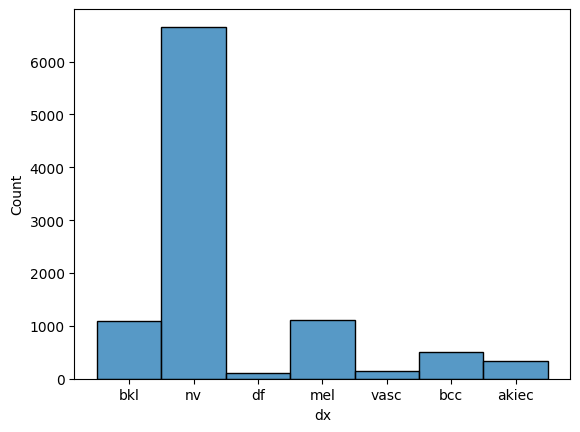

In [11]:
sns.histplot(data=metadata_df[metadata_df['age'].isna() != True], x='dx')

In [12]:
metadata_df['dx'].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


Por lo que veo tenemos un notorio desbalance de las clases con sesgo positivo hacia las clase **`nv`** con más de 6000 registros y un sesgo negativo para clases como **`df`** y **`vasc`** con poco más de 100 datos cada una.

Con respecto a los registros con edad `Null`, afortunadamente ningún registro pertenece a una de las clases con desbalance así que creo que podemos dropear esos registros sin problema.

Pero antes vamos a concatenear las imágenes con su respectiva metadata.

In [13]:
concatenated_df = pd.concat([metadata_df, images_csv], axis=1)

In [14]:
concatenated_df.head(5)

,dx,age,sex,localization,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,bkl,80.0,male,scalp,192,153,193,195,155,192,...,134,173,124,138,183,147,166,185,154,177
1,bkl,80.0,male,scalp,25,14,30,68,48,75,...,82,60,39,55,25,14,28,25,14,27
2,bkl,80.0,male,scalp,192,138,153,200,145,163,...,149,167,129,143,159,124,142,136,104,117
3,bkl,80.0,male,scalp,38,19,30,95,59,72,...,73,44,26,36,25,12,17,25,12,15
4,bkl,75.0,male,ear,158,113,139,194,144,174,...,201,209,166,185,172,135,149,109,78,92


In [15]:
#Dropeamos los registros que contienen edad null
print('Dimensiones dataframe antes: ', concatenated_df.shape)
concatenated_df.dropna(subset=['age'], inplace=True)
print('Dimensiones dataframe después: ', concatenated_df.shape)

Dimensiones dataframe antes:  (10015, 2356)
Dimensiones dataframe después:  (9958, 2356)


In [16]:
concatenated_df.isna().sum()

,0
dx,0
age,0
sex,0
localization,0
pixel0000,0
...,...
pixel2347,0
pixel2348,0
pixel2349,0
pixel2350,0


In [17]:
#Vamos a separar los datos en un df para el modelo 1D y otro para el modelo 2D
oneD_df = concatenated_df.loc[:, ['dx', 'age', 'sex', 'localization']]
twoD_df = concatenated_df.drop(columns=['dx', 'age', 'sex', 'localization'])

In [18]:
#Ahora vamos a proceder con la codificación de las categorias usando un OneHotEncoder
#Primero codificamos el sexo del paciente
from sklearn.preprocessing import OneHotEncoder

sex_encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

sex_encoded = sex_encoder.fit_transform(oneD_df[['sex']])

oneD_df = pd.concat([oneD_df, sex_encoded], axis=1).drop(columns='sex')

In [19]:
#Ahora codificamos la ubicación de la muestra
localization_encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

localization_encoded = localization_encoder.fit_transform(oneD_df[['localization']])

oneD_df = pd.concat([oneD_df, localization_encoded], axis=1).drop(columns='localization')

In [20]:
#Separamos los datos en X y y
X_oneD = oneD_df.drop(columns='dx')
y = oneD_df[['dx']]

#Ahora codificamos la clase a predecir
#Instanciamos el OneHotEncoder
cat_encoder = OneHotEncoder(sparse_output=False)


#Codificamos las clases
y_encoded = cat_encoder.fit_transform(y)

In [21]:
#Vamos a separar el conjunto de entrenamiento, test y validación para el modelo 1D y para el modelo 2D
#Para asegurarnos que ambos tengan los mismos datos vamos a coger los índices que luego asignaremos a cada conjunto para ambos modelos
from sklearn.model_selection import train_test_split


X_train_idx, X_test_idx, y_train, y_test = train_test_split(concatenated_df.index, y_encoded, test_size=.2, random_state=42)
X_train_idx, X_val_idx, y_train, y_val = train_test_split(X_train_idx, y_train, test_size=.2, random_state=42)

X_train_1D = X_oneD.loc[X_train_idx]
X_test_1D = X_oneD.loc[X_test_idx]
X_val_1D = X_oneD.loc[X_val_idx]

X_train_2D = twoD_df.loc[X_train_idx].values.reshape(-1, 28, 28, 3)
X_test_2D = twoD_df.loc[X_test_idx].values.reshape(-1, 28, 28, 3)
X_val_2D = twoD_df.loc[X_val_idx].values.reshape(-1, 28, 28, 3)

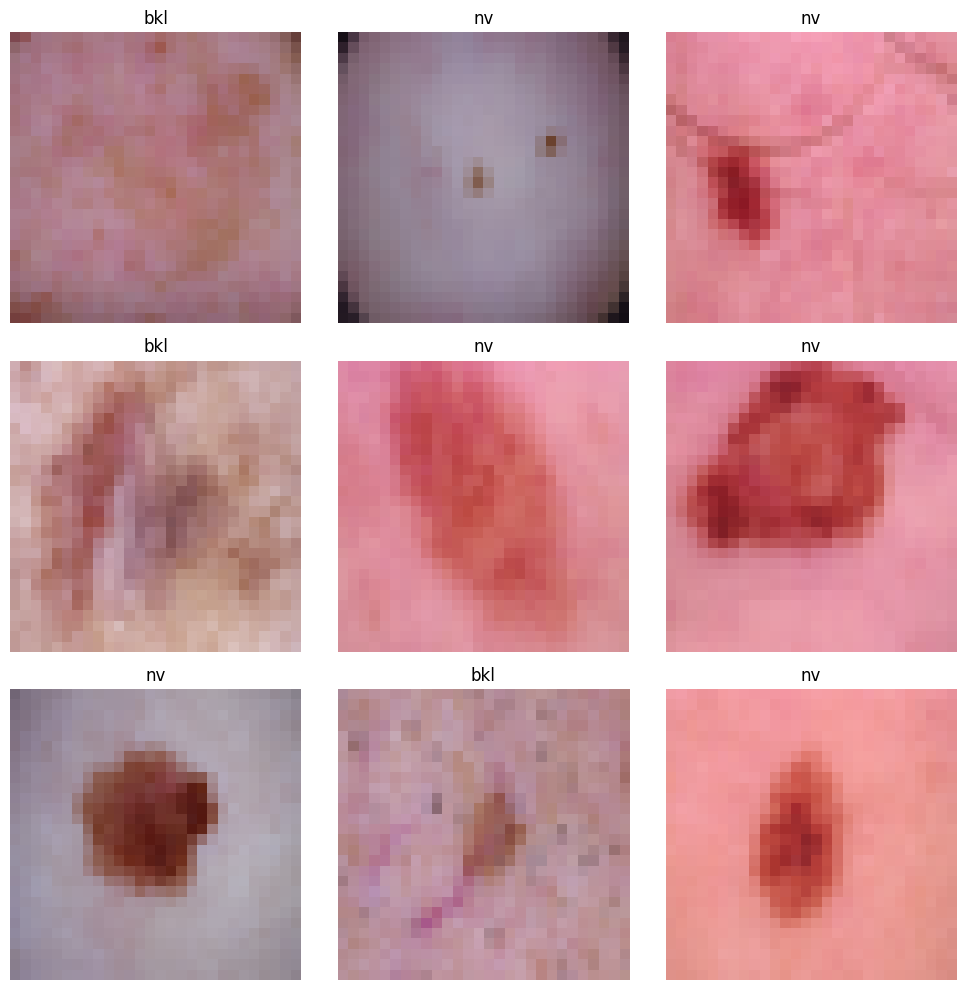

In [22]:
# Veamos algunas de las imagenes
_, axes = plt.subplots(3, 3, figsize=(10, 10))

for ax in axes.flat:
  data_idx = np.random.choice(len(X_train_2D))
  img = X_train_2D[data_idx]
  label = cat_encoder.categories_[0][np.argmax(y_train[data_idx])]
  ax.imshow(img)
  ax.set_title(label)
  ax.axis('off')
plt.tight_layout()
plt.show()

In [23]:
#Normalizamos la columna de edad
from sklearn.preprocessing import MinMaxScaler

#Instanciamos el escalador y lo entrenamos con el conjunto de train
scaler = MinMaxScaler()
age_scaler =  scaler.fit(X_train_1D[['age']])

#Normalizamos age en todos los conjuntos
X_train_1D['age'] = scaler.transform(X_train_1D[['age']])
X_test_1D['age'] = scaler.transform(X_test_1D[['age']])
X_val_1D['age'] = scaler.transform(X_val_1D[['age']])

# **1D Model**

In [24]:
#Importamos lo necesario para nuestra red de clasificación multiclase
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

#Definimos la dimensión de entrada
oneD_input_shape = X_train_1D.shape[1:]

#Creamos el input para el modelo
oneD_input = Input(shape=(oneD_input_shape), name='1D_Input')

#Primera capa: Se aplica un batch normalization antes de pasar por la función de activación
x = Dense(256)(oneD_input)
x = BatchNormalization()(x)
x = ReLU()(x)

#Segunda capa: Se aplica un batch normalization antes de pasar por la función de activación y luego se aplica un DropOut de un 25%
x = Dense(128)(oneD_input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

#Tercera capa: Se aplica un batch normalization antes de pasar por la función de activación y luego se aplica un DropOut de un 25%
x = Dense(64)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

#Tercera capa: Se aplica un batch normalization antes de pasar por la función de activación y luego se aplica un DropOut de un 25%
x = Dense(32, name="1D_features")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

#Capa de salida con 7 neuronas cada una perteneciendo a una clase y con una función softmax para volver probabilidades a las salidas
output = Dense(7, activation="softmax", name="1D_output")(x)

#Instanciamos el modelo
model_1D = Model(inputs=oneD_input, outputs=output)

#Compilamos el modelo con un optimizador adam con una taza de aprendizaje de 0.003
model_1D.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#Definimos un early stoppin para todos los modelos, tomaremos en cuenta la perdida de validación con una paciencia de 5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Entrenamos y almacenamos la info del entrenamiento
hist_1D = model_1D.fit(
    X_train_1D,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_1D, y_val),
    shuffle=True,
    callbacks=[early_stopping]
    )

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4679 - loss: 1.5229 - val_accuracy: 0.6920 - val_loss: 1.1675
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6724 - loss: 1.0849 - val_accuracy: 0.7039 - val_loss: 0.9581
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6806 - loss: 1.0330 - val_accuracy: 0.6982 - val_loss: 0.9216
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6844 - loss: 0.9943 - val_accuracy: 0.6957 - val_loss: 0.9108
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6823 - loss: 0.9917 - val_accuracy: 0.6945 - val_loss: 0.9048
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6828 - loss: 0.9812 - val_accuracy: 0.6951 - val_loss: 0.8991
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6826 - loss: 0.9846 - val_accuracy: 0.7033 - val_loss: 0.8989
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6873 - loss: 0.9650 - val_ac

In [25]:
model_1D.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1D_Input (InputLayer)                │ (None, 19)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1D_features (Dense)                  │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1D_output (Dense)                    │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,175 (160.84 KB)

 Trainable params: 13,575 (53.03 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 27,152 (106.07 KB)

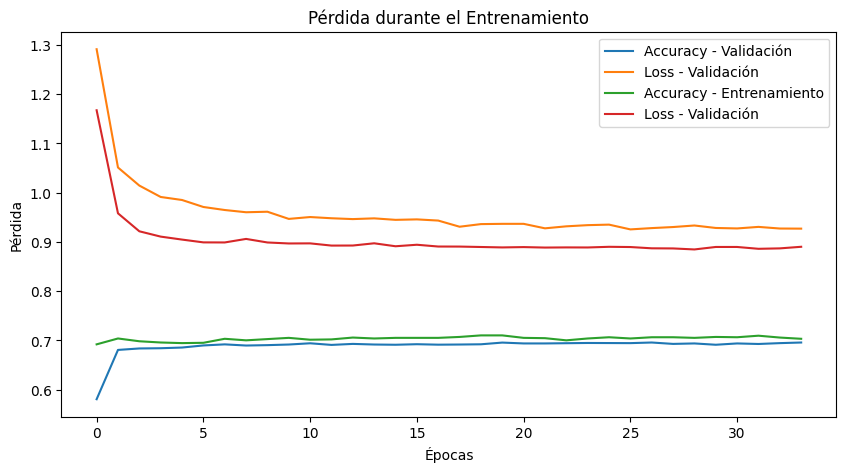

In [26]:
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['accuracy'], label='Accuracy - Validación')
  plt.plot(history.history['loss'], label='Loss - Validación')
  plt.plot(history.history['val_accuracy'], label='Accuracy - Entrenamiento')
  plt.plot(history.history['val_loss'], label='Loss - Validación')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.title('Pérdida durante el Entrenamiento')
  plt.legend()
  plt.show()

#Graficamos el aprendizaje
plot_history(hist_1D)

In [27]:
model_1D.evaluate(X_test_1D, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6858 - loss: 0.8921


[0.8801215887069702, 0.6957831382751465]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.00      0.00      0.00        91
         bkl       0.38      0.34      0.36       225
          df       0.00      0.00      0.00        29
         mel       0.17      0.01      0.02       225
          nv       0.74      0.98      0.84      1336
        vasc       0.00      0.00      0.00        21

    accuracy                           0.70      1992
   macro avg       0.18      0.19      0.18      1992
weighted avg       0.56      0.70      0.61      1992



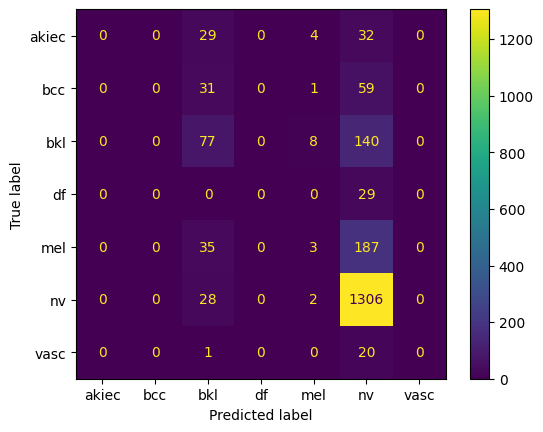

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

y_pred_1D = model_1D.predict(X_test_1D)

def show_confussionMatrix_and_report(y_pred):
  y_test_cm = cat_encoder.categories_[0][np.argmax(y_test, axis=1)]
  y_pred_cm = cat_encoder.categories_[0][np.argmax(y_pred, axis=1)]

  ConfusionMatrixDisplay.from_predictions(y_test_cm, y_pred_cm, labels=cat_encoder.categories_[0]), print(classification_report(y_test_cm, y_pred_cm))

show_confussionMatrix_and_report(y_pred_1D)

El desbalance de datos definitivamente no favorece a nuestro modelo, vemos como las clases con menos registros no aprendió absolutamente nada, en cambio con la clase mayoritaria fue lo contrario, habiendo no dejado pasar la clase un 98% de las veces.

 # **2D Model**

In [29]:
#Importamos las capas para el modelo convolucional
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.regularizers import l2

#Definimos la dimensión de entrada
twoD_input_shape = X_train_2D.shape[1:]

#Creamos el input para el modelo
model_2D_input = Input(shape=(twoD_input_shape), name='2D_input')

#Primera capa de convolución con 16 filtros para captar detalles generales
x = Conv2D(16, kernel_size=(3,3), padding='same')(model_2D_input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

#Segunda capa de  convolución con 32
x = Conv2D(32, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

#Segunda capa de  convolución con 64
x = Conv2D(64, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

#Segunda capa de  convolución con 128 para captar patrones y detalles complejos
x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = AveragePooling2D(pool_size=(2,2))(x)

#Aplanamos la matriz de filtros
x = Flatten()(x)

#Primera capa densa, aplicamos un regularizador de Ridge para evitar el overfitting
x = Dense(128, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.5)(x)

#Segunda capa densa, aplicamos un regularizador de Ridge para evitar el overfitting
x = Dense(64, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.5)(x)

#Tercera capa densa
x = Dense(32, activation='relu', name='2D_features')(x)
x = Dropout(0.5)(x)

#Capa de salida
output = Dense(7, activation='softmax', name='2D_output')(x)

#Instancia del modelo 2D
model_2D = Model(inputs=model_2D_input, outputs=output)

#Compilamos el modelo con un optimizador adam con una taza de aprendizaje de 0.003
model_2D.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#Entrenamos y almacenamos la info del entrenamiento
hist_2D = model_2D.fit(
    X_train_2D,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_2D, y_val),
    shuffle=True,
    callbacks=[early_stopping]
  )


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.2775 - loss: 11.7637 - val_accuracy: 0.6769 - val_loss: 9.2164
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5595 - loss: 8.8133 - val_accuracy: 0.6769 - val_loss: 6.9546
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6400 - loss: 6.7044 - val_accuracy: 0.6769 - val_loss: 5.3351
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6526 - loss: 5.1703 - val_accuracy: 0.6769 - val_loss: 4.1097
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6640 - loss: 3.9886 - val_accuracy: 0.6769 - val_loss: 3.2003
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6609 - loss: 3.1846 - val_accuracy: 0.6769 - val_loss: 2.5551
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6643 - loss: 2.5301 - val_accuracy: 0.6769 - val_loss: 2.0750
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6597 - loss: 2.0810 - val_a

In [30]:
model_2D.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 2D_input (InputLayer)                │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 375,479 (1.43 MB)

 Trainable params: 124,999 (488.28 KB)

 Non-trainable params: 480 (1.88 KB)

 Optimizer params: 250,000 (976.57 KB)

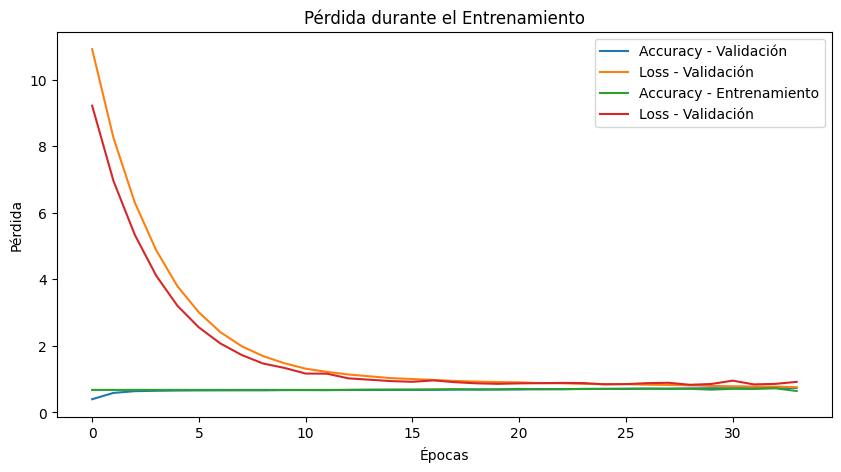

In [31]:
plot_history(hist_2D)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.33      0.01      0.02        91
         bkl       0.30      0.44      0.36       225
          df       0.00      0.00      0.00        29
         mel       0.46      0.32      0.37       225
          nv       0.83      0.93      0.88      1336
        vasc       0.00      0.00      0.00        21

    accuracy                           0.71      1992
   macro avg       0.27      0.24      0.23      1992
weighted avg       0.66      0.71      0.67      1992



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


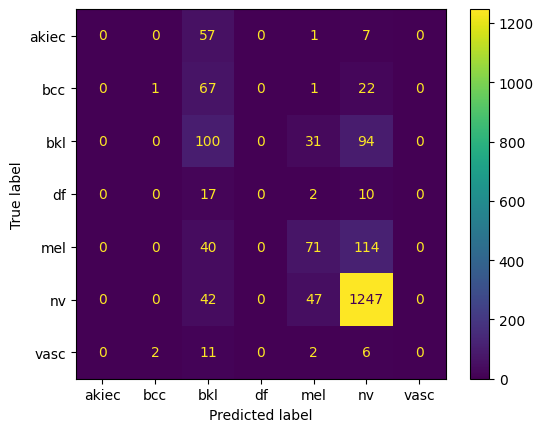

In [32]:
y_pred_2D = model_2D.predict(X_test_2D)

show_confussionMatrix_and_report(y_pred_2D)

In [33]:
model_2D.evaluate(X_test_2D, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7098 - loss: 0.8379


[0.8192465305328369, 0.7123494148254395]

Como podemos ver por las métricas, en ambos modelos (1D y 2D) aunque tenga un acuraccy de casi un 70% (2D) esto no es completamente así, ya que de viendo la precision para cada clase podemos ver que en varias clases el modelo no pudo aprender las carácteristicas significativas y no puede predecir correctamente esas clases.
En el caso de 2D vemos la clases df y vasc con un 0% de aciertos, coinciendiendo con lo que vimos antes, clases con muy pocos registros, en cambio clases como nv vemos como un 99% de veces que el modelo se enfrentaba a casos de esa clase lo acertaba.

# Fine tuning a ResNet50

In [34]:
#Importamos resnet
from tensorflow.keras.applications import ResNet50

#Definimos su dimensión de entrada
resnet_input = Input(shape=twoD_input_shape, name='twoD_inception')

#Instanciamos resnet
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=resnet_input)

#Congelamos casi todas las capas
for layer in resnet.layers[:-10]:
  layer.trainable = False

#Tomamos la salida de caracteristicas de resnet
resnet_output = Flatten()(resnet.output)

#Creamos una red capas densas para hacer la clasificación
x = Dense(256)(resnet_output)
x = ReLU()(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = ReLU()(x)
x = Dropout(0.5)(x)

x = Dense(64)(x)
x = ReLU()(x)
x = Dropout(0.5)(x)

x = Dense(32)(x)
x = ReLU()(x)
x = Dropout(0.5)(x)

#Capa de salida
output = Dense(7, activation='softmax')(x)

#Instanciamos el modelo
ft_model = Model(inputs=resnet_input, outputs=output)

#Compilamos el modelo
ft_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#Entrenamos el modelo
hist_ft_model = ft_model.fit(
    X_train_2D,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_2D, y_val),
    shuffle=True,
    callbacks=[early_stopping]
  )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.1845 - loss: 3.7935 - val_accuracy: 0.6750 - val_loss: 1.3753
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3915 - loss: 1.7566 - val_accuracy: 0.6769 - val_loss: 1.1638
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4804 - loss: 1.5163 - val_accuracy: 0.6788 - val_loss: 1.0422
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5505 - loss: 1.3314 - val_accuracy: 0.6782 - val_loss: 1.0379
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5905 - loss: 1.2569 - val_accuracy: 0.6794 - val_loss: 0.9768
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6088 - loss: 1.2136 - val_accuracy: 0.6775 - val_loss: 0.9559
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6161 - loss: 1.1703 - val_accuracy: 0.6769 - val_loss: 0.9490
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━

In [35]:
ft_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ twoD_inception            │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 34, 34, 3)      │              0 │ twoD_inception[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 14, 14, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 14, 14, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 14, 14, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 16, 16, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 7, 7, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 7, 7, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 7, 7, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 7, 7, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 7, 7, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 34,223,063 (130.55 MB)

 Trainable params: 5,033,671 (19.20 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 10,067,344 (38.40 MB)

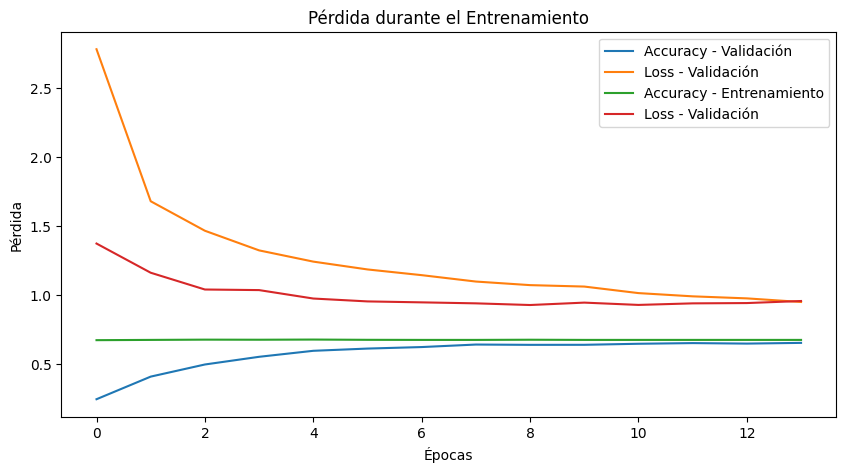

In [36]:
plot_history(hist_ft_model)

# Hito #3 (Late Fusion Model)


In [37]:
#Importamos el modelo funcional, input y concatenate
from tensorflow.keras.layers import Concatenate

#Aprovecharemos los modelos que tenemos ya entrenados,por lo que vamos a congelar sus capas
for layer in model_1D.layers:
    layer.trainable = False

for layer in model_2D.layers:
    layer.trainable = False

#Definimos las dimensiones de entradas
oneD_input_late = Input(shape=(oneD_input_shape), name='1D_input')
twoD_input_late = Input(shape=(twoD_input_shape), name='2D_input')

#Pasamos la entrada a cada modelo
oneD_pred = model_1D(oneD_input_late)
twoD_pred = model_2D(twoD_input_late)

#Concatenamos las salidas
merged_pred = Concatenate()([oneD_pred, twoD_pred])

#Capa intermedia densa sencilla
pre_output = Dense(32, activation='relu')(merged_pred)
pre_output = Dropout(0.3)(pre_output)

#Capa de salida
output = Dense(7, activation='softmax', name='late_model_output')(pre_output)

#Instanciamos el modelo de fusion tardia
late_fusion_model = Model(inputs=[oneD_input_late, twoD_input_late], outputs=output)

#Compilamos el modelo
late_fusion_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#Entrenamos el modelo
hist_late_fusion = late_fusion_model.fit(
    [X_train_1D, X_train_2D],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_1D, X_val_2D], y_val),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.3401 - loss: 1.8189 - val_accuracy: 0.6769 - val_loss: 0.9748
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6797 - loss: 0.9480 - val_accuracy: 0.7152 - val_loss: 0.8022
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7044 - loss: 0.8140 - val_accuracy: 0.7277 - val_loss: 0.7785
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7347 - loss: 0.7432 - val_accuracy: 0.7334 - val_loss: 0.7668
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7326 - loss: 0.7149 - val_accuracy: 0.7403 - val_loss: 0.7574
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7358 - loss: 0.7307 - val_accuracy: 0.7371 - val_loss: 0.7493
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7370 - loss: 0.7113 - val_accuracy: 0.7378 - val_loss: 0.7470
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7479 - loss: 0.6926 - val_ac

In [38]:
late_fusion_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1D_input (InputLayer)     │ (None, 19)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_input (InputLayer)     │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 7)              │         14,023 │ 1D_input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 7)              │        125,479 │ 2D_input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 14)             │              0 │ functional[0][0],      │
│                           │                        │                │ functional_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │            480 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 32)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ late_model_output (Dense) │ (None, 7)              │            231 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 141,637 (553.27 KB)

 Trainable params: 711 (2.78 KB)

 Non-trainable params: 139,502 (544.93 KB)

 Optimizer params: 1,424 (5.57 KB)

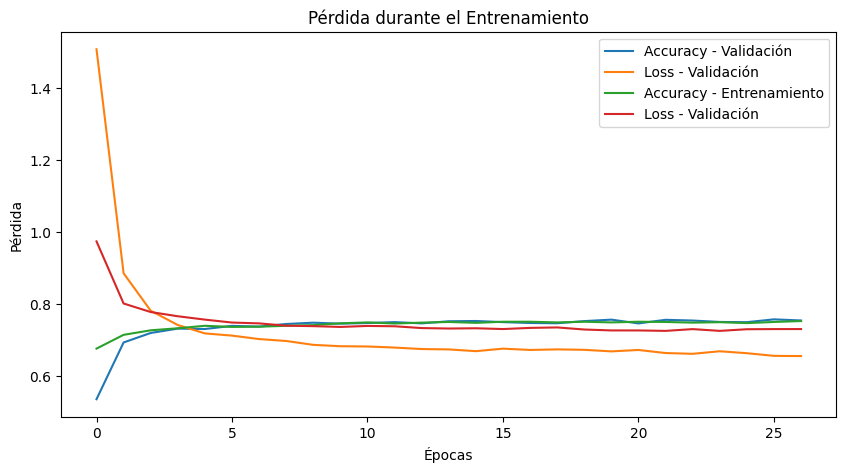

In [39]:
plot_history(hist_late_fusion)

In [40]:
late_fusion_model.evaluate([X_test_1D, X_test_2D], y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7380 - loss: 0.7521


[0.7164568305015564, 0.7459839582443237]

In [41]:
y_pred_lfm = late_fusion_model.predict([X_test_1D, X_test_2D])

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.36      0.51      0.42        91
         bkl       0.42      0.41      0.42       225
          df       0.00      0.00      0.00        29
         mel       0.46      0.41      0.43       225
          nv       0.87      0.94      0.90      1336
        vasc       0.00      0.00      0.00        21

    accuracy                           0.75      1992
   macro avg       0.30      0.32      0.31      1992
weighted avg       0.70      0.75      0.72      1992



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


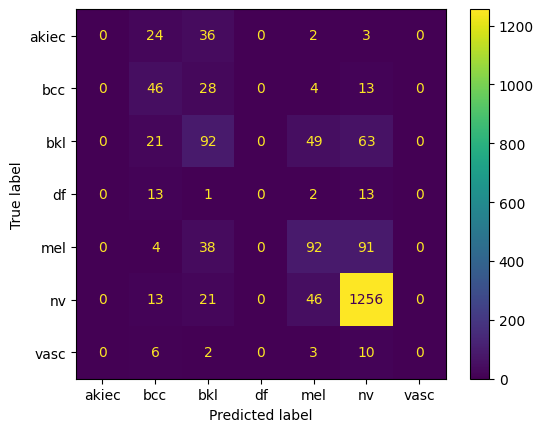

In [42]:
show_confussionMatrix_and_report(y_pred_lfm)

# Hito #4 (Early Fusion Model)

In [43]:
for layer in model_1D.layers:
    layer.trainable = False

for layer in model_2D.layers:
    layer.trainable = False

oneD_input_early = Input(shape=(oneD_input_shape), name='1D_input')
twoD_input_early = Input(shape=(twoD_input_shape), name='2D_input')

oneD_intermediate = Model(inputs=model_1D.input, outputs=model_1D.get_layer('1D_features').output)
twoD_intermediate = Model(inputs=model_2D.input, outputs=model_2D.get_layer('2D_features').output)

oneD_features = oneD_intermediate(oneD_input_early)
twoD_features = twoD_intermediate(twoD_input_early)

merged_features = Concatenate()([oneD_features, twoD_features])


x = Dense(128, activation='relu')(merged_features)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(7, activation='softmax', name='efm_output')(x)

early_fusion_model = Model(inputs=[oneD_input_early, twoD_input_early], outputs=output)

early_fusion_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

early_fusion_model_hist = early_fusion_model.fit(
    [X_train_1D,X_train_2D],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_1D, X_val_2D], y_val),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6180 - loss: 1.1134 - val_accuracy: 0.7284 - val_loss: 0.7697
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7149 - loss: 0.7670 - val_accuracy: 0.7503 - val_loss: 0.7811
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7336 - loss: 0.7007 - val_accuracy: 0.7491 - val_loss: 0.7404
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7482 - loss: 0.6716 - val_accuracy: 0.7484 - val_loss: 0.7438
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7533 - loss: 0.6617 - val_accuracy: 0.7465 - val_loss: 0.7391
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7577 - loss: 0.6528 - val_accuracy: 0.7434 - val_loss: 0.7353
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7596 - loss: 0.6576 - val_accuracy: 0.7553 - val_loss: 0.7104
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7604 - loss: 0.6724 - val_a

In [44]:
early_fusion_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1D_input (InputLayer)     │ (None, 19)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_input (InputLayer)     │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 32)             │         13,664 │ 1D_input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_5 (Functional) │ (None, 32)             │        125,248 │ 2D_input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64)             │              0 │ functional_4[0][0],    │
│ (Concatenate)             │                        │                │ functional_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 128)            │          8,320 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128)            │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │          8,256 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 64)             │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 32)             │          2,080 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 32)             │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efm_output (Dense)        │ (None, 7)              │            231 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 195,575 (763.97 KB)

 Trainable params: 18,887 (73.78 KB)

 Non-trainable params: 138,912 (542.62 KB)

 Optimizer params: 37,776 (147.57 KB)

In [45]:
early_fusion_model.evaluate([X_train_1D, X_train_2D], y_train)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7896 - loss: 0.5530


[0.5451059937477112, 0.7948838472366333]

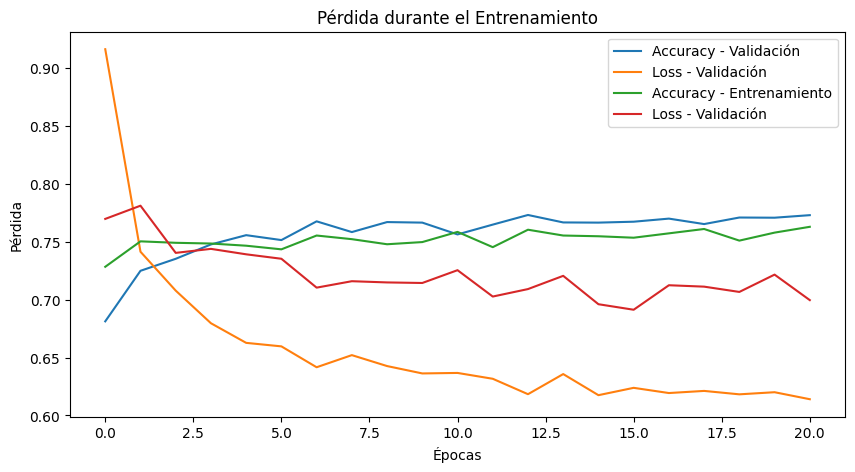

In [46]:
plot_history(early_fusion_model_hist)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

       akiec       0.32      0.14      0.19        65
         bcc       0.48      0.43      0.45        91
         bkl       0.42      0.43      0.42       225
          df       0.67      0.34      0.45        29
         mel       0.48      0.44      0.46       225
          nv       0.88      0.94      0.90      1336
        vasc       0.67      0.10      0.17        21

    accuracy                           0.76      1992
   macro avg       0.56      0.40      0.44      1992
weighted avg       0.74      0.76      0.74      1992



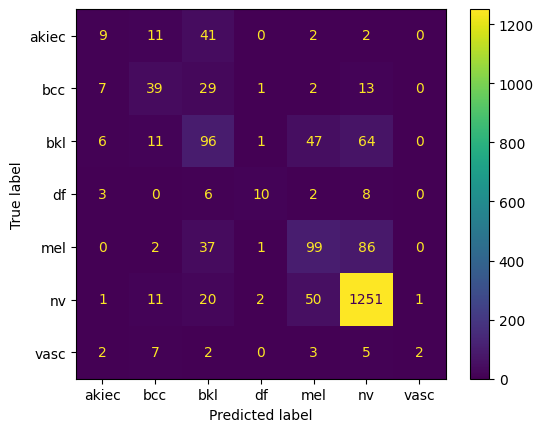

In [47]:
y_pred_efm = early_fusion_model.predict([X_test_1D, X_test_2D])
show_confussionMatrix_and_report(y_pred_efm)

# Conclusiones
Vemos que casi todos los modelos tienen rendimientos muy similares; con un mejor rendimiento para el modelo de Early Fusion, pero el modelo Late Fusion está por detras con casi nada de diferencia.

También debido a la falta de datos para ciertas clases el modelo no pudo aprender sus características relevates, llevando a que en algunos modelos no acertara ni una sola predicción en 3 clases.

In [96]:
!git add .